In [1]:
import pandas as pd
import numpy as np
import dask
from sklearn.pipeline import Pipeline


from dask.distributed import Client, LocalCluster
from dask_ml.model_selection import train_test_split


import joblib
from joblib import parallel_backend

import timeit

from dask_ml.model_selection import GridSearchCV
from dask_ml.model_selection import train_test_split

from sklearn.tree import DecisionTreeRegressor


from dask_ml.wrappers import Incremental

from sklearn.metrics import mean_squared_error


from dask_ml.preprocessing import StandardScaler


from sklearn.pipeline import make_pipeline

from sklearn.linear_model import PassiveAggressiveRegressor

from sklearn.metrics import explained_variance_score

import dask.array as da

import matplotlib.pyplot as plt

import pickle

from pandas.plotting import register_matplotlib_converters


A timer is started to determine the runtime of the entire project after importing the packages.

In [2]:
start2 = timeit.default_timer()

After starting the timer, I will run the local cluster from the Dask library.

In [3]:
cluster = LocalCluster(threads_per_worker = 1, n_workers = 2)

client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://127.0.0.1:64860 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 2 Memory: 8.59 GB


My local cluster has 2 workers for each core of my dual core laptop.
I create a data frame from my cleaned data.

In [5]:
df = pd.read_csv('large_cleaned_data.csv').drop('Unnamed: 0', 1)

Next I will graph the average opening price for the stock data over years.

In [6]:
plot_df = df[['Date','Open','Close']].copy()


In [7]:
plot_df['Date'] = plot_df['Date'].astype('datetime64')

In [8]:
plot_df['Date'] = plot_df.Date.apply(lambda x: x.year)

In [9]:
plot_df = plot_df.groupby('Date').median()



The graph of the average opening price for the stock market date over years:

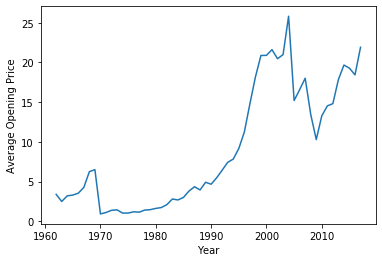

In [10]:
plt.plot(plot_df.index.values, plot_df.Open.values)
plt.ylabel('Average Opening Price')
plt.xlabel('Year')
plt.show()

The graph of the average closing price for the stock market date over years:

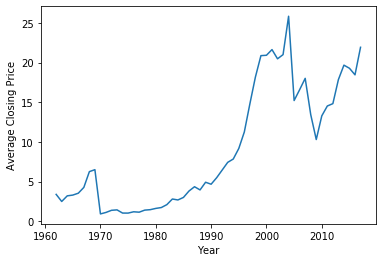

In [11]:
plt.plot(plot_df.index.values, plot_df.Close.values)
plt.ylabel('Average Closing Price')
plt.xlabel('Year')
plt.show()

The shape of the average opening and closing prices for stocks over time looks identical from inspection, so there is undoubtedly very strong correlation between the two features.

Now let's look at two correlation matrices that will be used to determine what sort of correlation the features have.

The Kendall method will measure the nonlinear association of the features and the Pearson method will measure any linear associations:

In [12]:
df.corr(method = 'kendall')

,Open,High,Low,Close,Volume
Open,1.000000,0.990558,0.990149,0.987289,0.100327
High,0.990558,1.000000,0.985858,0.990813,0.101652
Low,0.990149,0.985858,1.000000,0.990635,0.098998
Close,0.987289,0.990813,0.990635,1.000000,0.100360
Volume,0.100327,0.101652,0.098998,0.100360,1.000000


In [13]:
df.corr(method = 'pearson')

,Open,High,Low,Close,Volume
Open,1.000000,0.999713,0.999374,0.998930,-0.001500
High,0.999713,1.000000,0.999448,0.999476,-0.001498
Low,0.999374,0.999448,1.000000,0.999651,-0.001506
Close,0.998930,0.999476,0.999651,1.000000,-0.001501
Volume,-0.001500,-0.001498,-0.001506,-0.001501,1.000000


As can be clearly seen, there is very high linear and non-linear correlation. This high multicollinearity will not be a problem though since the objective of this project is prediction.

A paramter and its values to be grid-searched over are chosen.
'C' represents maximum step size (regularization). Optimizing this will prevent overfitting.

Next the predictors and response variables will be separated from the dataframe, scaled, and then train-test-split will be applied:

In [14]:
X, y = df.drop(['Date', 'Close'], 1), df[['Close']]

In [15]:
X = StandardScaler().fit_transform(X)
y = StandardScaler().fit_transform(y)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)


The variables from the train-test-split will be transformed into dask arrays and stored in RAM for faster access when building the model:

In [17]:
X_train_da = da.from_array(X_train.values, chunks = (1000000, 4))
y_train_da = da.from_array(y_train.values, chunks = (1000000, 1))

X_test_da = da.from_array(X_test.values, chunks = (1000000, 4))
y_test_da = da.from_array(y_test.values, chunks = (1000000, 1))

In [18]:
X_train_da, y_train_da = dask.persist(X_train_da, y_train_da)
X_test_da, y_test_da = dask.persist(X_test_da, y_test_da)

A paramter and its values to be grid-searched over are chosen next.
'C' represents maximum step size (regularization). Optimizing this will prevent overfitting.

Three values are chosen.

In [19]:
parameters = {'C': [.5,1,2]}

Grid search will now be run and timed.

NOTE: The numbers that appear at the bottom of cells throughout the notebook are the number of seconds the process takes to complete once the cell runs.

In [20]:
start = timeit.default_timer()
search = GridSearchCV(PassiveAggressiveRegressor(), parameters, cv = 3).fit(X_train_da, y_train_da.ravel())
end = timeit.default_timer()

print(end - start)

185.167600504


Then the incremental wrapper from Dask is used to feed the data stored as dask arrays to the estimator, the PassiveAggressiveRegressor, blockwise.  

The incremental wrapper provides a bridge between Dask objects and estimators implementing the partial_fit API. Since the PassiveAggressiveRegressor has a partial fit method, this will work just fine.

In [21]:
inc = Incremental(PassiveAggressiveRegressor(C=search.best_estimator_.get_params()['C']))

start = timeit.default_timer()
inc.fit(X_train_da, y_train_da.ravel())
end = timeit.default_timer()

print(end - start)

3.063699636000024


The R2 score, explained variance score, and mean-squared error are calculated: 

In [22]:
# R2 score

inc.score(X_test_da, y_test_da)

0.9975926779282441

In [23]:
# explained variance score

explained_variance_score(y_test, inc.predict(X_test))

0.9977152731957063

In [24]:
# mean-squared error

mean_squared_error(y_test, inc.predict(X_test))

0.0022653224204865507

Let's try one feature now for the predictor variable since the scores are so high.

Let's find out if the model evaluation scores are still high when only opening price is used as a predictor. 

New train and test predictor variables are created as Dask arrays from the earlier train-test-split. The only difference is that these two new predictor variables will only contain the opening price feature for the stocks:

In [25]:
X_train_da2 = da.from_array(X_train.Open.values.reshape(-1,1), chunks = (1000000, 1))

X_test_da2 = da.from_array(X_test.Open.values.reshape(-1,1), chunks = (1000000, 1))

In [26]:
X_train_da2, X_test_da2 = dask.persist(X_train_da2, X_test_da2)

A second grid search is run, a second incremental wrapper is fit, and the model evaluation scores are determined:

In [27]:
start = timeit.default_timer()
search2 = GridSearchCV(PassiveAggressiveRegressor(), parameters, cv = 3).fit(X_train_da2, y_train_da.ravel())
end = timeit.default_timer()

print(end - start)

140.412606295


In [28]:
inc2 = Incremental(PassiveAggressiveRegressor(C=search2.best_estimator_.get_params()['C']))

start = timeit.default_timer()
inc2.fit(X_train_da2, y_train_da.ravel())
end = timeit.default_timer()

print(end - start)

2.584024975000034


In [29]:
# R2 score

inc2.score(X_test_da2, y_test_da)

0.9977962890559248

In [30]:
# explained variance score

explained_variance_score(y_test, inc2.predict(X_test.Open.values.reshape(-1,1)))

0.998213167445296

In [31]:
# mean-squared error

mean_squared_error(y_test, inc2.predict(X_test.Open.values.reshape(-1,1)))

0.002073721613096855

One variable seems to suffice. The scores of this new model indicate that the performance of the first model is still intact.


Let's compare these results to the results from a different data set.
The model was trained on stock market data from 2005 to 2010.
Let's train it on a different set of stock market data from 2000 to 2020.

A new data frame is created using the other data set:

In [32]:
df2 = pd.read_csv('cleaned_data.csv').rename(columns = {'Unnamed: 0':'date'})

In [33]:
df2.date = pd.to_datetime(df2.date)

This new data is for a single stock: JP Morgan.
The opening and closing price for the stock will be graphed:

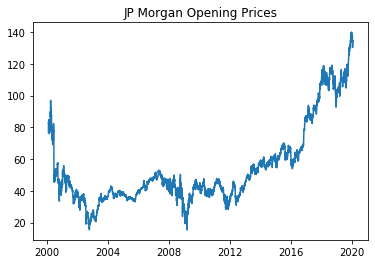

In [34]:
# JP Morgan Opening prices


register_matplotlib_converters()

plt.plot(df2.date, df2.open)
plt.title('JP Morgan Opening Prices')
plt.show()

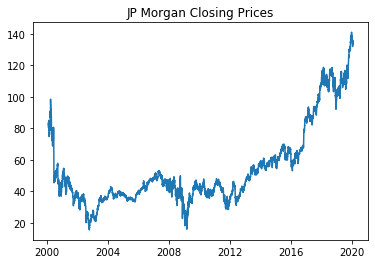

In [35]:
# JP Morgan Closing prices


plt.plot(df2.date, df2.close)
plt.title('JP Morgan Closing Prices')
plt.show()

The opening and closing prices for JP Morgan from 2000 to 2020 look identical, so there is high correlation between the two features just like in the first data set.

Let's graph the closing price of the JP Morgan stock against the predictions the model made just to get a visual representation of how accurate the model was in predicting the future stock prices:

In [36]:
df2['predictions'] = inc2.predict(df2.open.values.reshape(-1, 1))

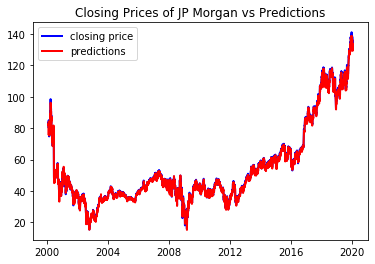

In [37]:
plt.plot('date', 'close', data=df2, marker='', color='blue', linewidth=2, 
         label='closing price')
plt.plot('date', 'predictions', data=df2, marker='', color='red', linewidth=2, 
         label="predictions")
plt.legend()
plt.title('Closing Prices of JP Morgan vs Predictions')
plt.show()

The closing price and the model's prediction for the closing price show almost complete overlap. 

The reason for that is clear. The explained variance score is very high:

In [38]:
explained_variance_score(df2.close.values, 
                         df2.predictions)

0.9987173569399054

Finally, the model is pickled to prepare it for the Flask application.

In [44]:
import pickle
with open('model.pkl', 'wb') as fid:
    pickle.dump(inc2, fid, 2) 

The entire run time of everything is calculated:

In [45]:
end2 = timeit.default_timer()

print(end2 - start2)

574.559311883
